In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from UNet import UNet , UNetPlusPlus, AttentionUNet,FCN8s, DeepLabV3
import random
from torch.utils.data import DataLoader,Dataset
from calculate import  calculate_metrics , DiceLoss, seed_torch,FocalLoss, CombinedLoss

import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

import torch.nn.functional as F

seed_torch()


def count_images_in_directory(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    files = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(valid_extensions)])
    return files

class Data_Loader(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = count_images_in_directory(self.image_dir)
        self.masks = count_images_in_directory(self.mask_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = Image.open(img_name).convert("L")
        image = transforms.ToTensor()(image)
        
        mask = Image.open(mask_name).convert('L')
        mask = transforms.ToTensor()(mask)
        
        return image, mask

# 路径设置
new_image_dir = os.path.join('new2', 'images')
new_mask_dir = os.path.join('new2', 'masks')
new_dataset = Data_Loader(new_image_dir, new_mask_dir)

# 拆分为训练集和验证集
train_size = int(0.8 * len(new_dataset))
test_size = len(new_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [train_size, test_size])

# 加载 CycleGAN 生成的数据
cyclegan_image_dir = os.path.join('data_aug', 'images')
cyclegan_mask_dir = os.path.join('data_aug', 'masks')
cyclegan_dataset = Data_Loader(cyclegan_image_dir, cyclegan_mask_dir)

# 可选合并训练集
data_aug = False

if data_aug:
    combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, cyclegan_dataset])
    print(f"Combined train dataset size: {len(combined_train_dataset)}")  # 输出合并后的训练集大小
    train_loader = DataLoader(dataset=combined_train_dataset, batch_size=1, shuffle=True)
else:
    print(f"Train dataset size: {len(train_dataset)}")  # 输出原始训练集大小
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
print(f"test dataset size: {len(test_dataset)}")

# 网络训练模块
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(in_channels=1, num_classes=1)  # 设置输出通道为1S
#net = DeepLabV3(in_channels=1, num_classes=1)
net.to(device)

#criterion = DiceLoss()
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

best_dice_score = 0.0  # 记录最好的Dice分数
patience = 3  # 提前停止的耐心，基于Dice分数，如果性能连续下降这么多次就停止训练
trigger_times = 0  # 用于记录Dice分数下降的次数

for epoch in range(50):
    net.train()
    running_loss = 0.0

    # 训练阶段
    for image, label in train_loader:
        optimizer.zero_grad()
        pred = net(image.to(device))

        if label.dim() == 3:
            label = label.unsqueeze(1).float()
        elif label.dim() == 4:
            label = label.float()

        loss = criterion(pred, label.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        torch.cuda.empty_cache()

    # 验证阶段
    net.eval()
    acc = 0.0
    total = 0
    iou_total = 0.0
    dice_total = 0.0
    f1_total = 0.0
    val_loss = 0.0  # 验证集损失
    with torch.no_grad():
        for test_image, test_label in test_loader:
            outputs = net(test_image.to(device))
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # 0.5阈值

            if test_label.dim() == 3:
                test_label = test_label.unsqueeze(1).float()
            elif test_label.dim() == 4:
                test_label = test_label.float()

            loss = criterion(outputs, test_label.to(device))
            val_loss += loss.item()  # 计算验证集损失

            iou_score, dice_score, precision, recall, f1 = calculate_metrics(preds.cpu(), test_label.cpu())


            iou_total += iou_score
            dice_total += dice_score
            f1_total += f1

            acc += (preds == test_label.to(device)).sum().item() / (test_label.size(2) * test_label.size(3))
            total += test_label.size(0)

        # 计算平均准确率和损失
        accurate = acc / total
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        avg_iou = iou_total / len(test_loader)
        avg_dice = dice_total / len(test_loader)
        avg_f1 = f1_total / len(test_loader)

    # 打印训练和验证的损失、准确率、F1分数、Precision、Recall、IoU和Dice
    print(f"[epoch {epoch + 1}] train_loss: {avg_train_loss:.3f} val_loss: {avg_val_loss:.3f} val_accuracy: {accurate * 100:.3f}%")
    print(f"IoU: {avg_iou:.3f}, Dice: {avg_dice:.3f},F1 Score: {avg_f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    # 检查模型是否比之前的模型好
    if avg_dice > best_dice_score:
        best_dice_score = avg_dice
        trigger_times = 0  # 重置过拟合计数
        #torch.save(net.state_dict(), 'best_model.pth')  # 保存当前最好的模型
    else:
        trigger_times += 1
        print(f"Dice score has decreased! Trigger times: {trigger_times}")

    # 如果Dice分数连续下降几次，则可能是过拟合，可以提前停止
    if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch + 1} based on Dice score.")
        break

    # 调整学习率
    scheduler.step()


Train dataset size: 768
test dataset size: 192


KeyboardInterrupt: 

In [6]:
def segment_single_image(net, image_path, save_dir="seg_result"):
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 确保模型在评估模式
    net.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    # 图像预处理
    image = Image.open(image_path).convert("L")
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        # 模型预测
        output = net(image_tensor)
        pred = torch.sigmoid(output)
        pred = (pred > 0.1).float()  # 使用与原代码相同的阈值
        
        # 保存预测结果
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        pred_image = pred.squeeze().cpu().numpy() * 255
        pred_image = Image.fromarray(pred_image.astype(np.uint8))
        save_path = os.path.join(save_dir, f"{image_name}_seg.png")
        pred_image.save(save_path)
        
        return save_path

# 使用示例
image_path = "new2/images/1_image_0.png"  # 替换为您的图片路径
result_path = segment_single_image(net, image_path)

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(Image.open(image_path), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(Image.open(result_path), cmap='gray')
plt.title('Segmentation Result')
plt.axis('off')
plt.show()

NameError: name 'net' is not defined

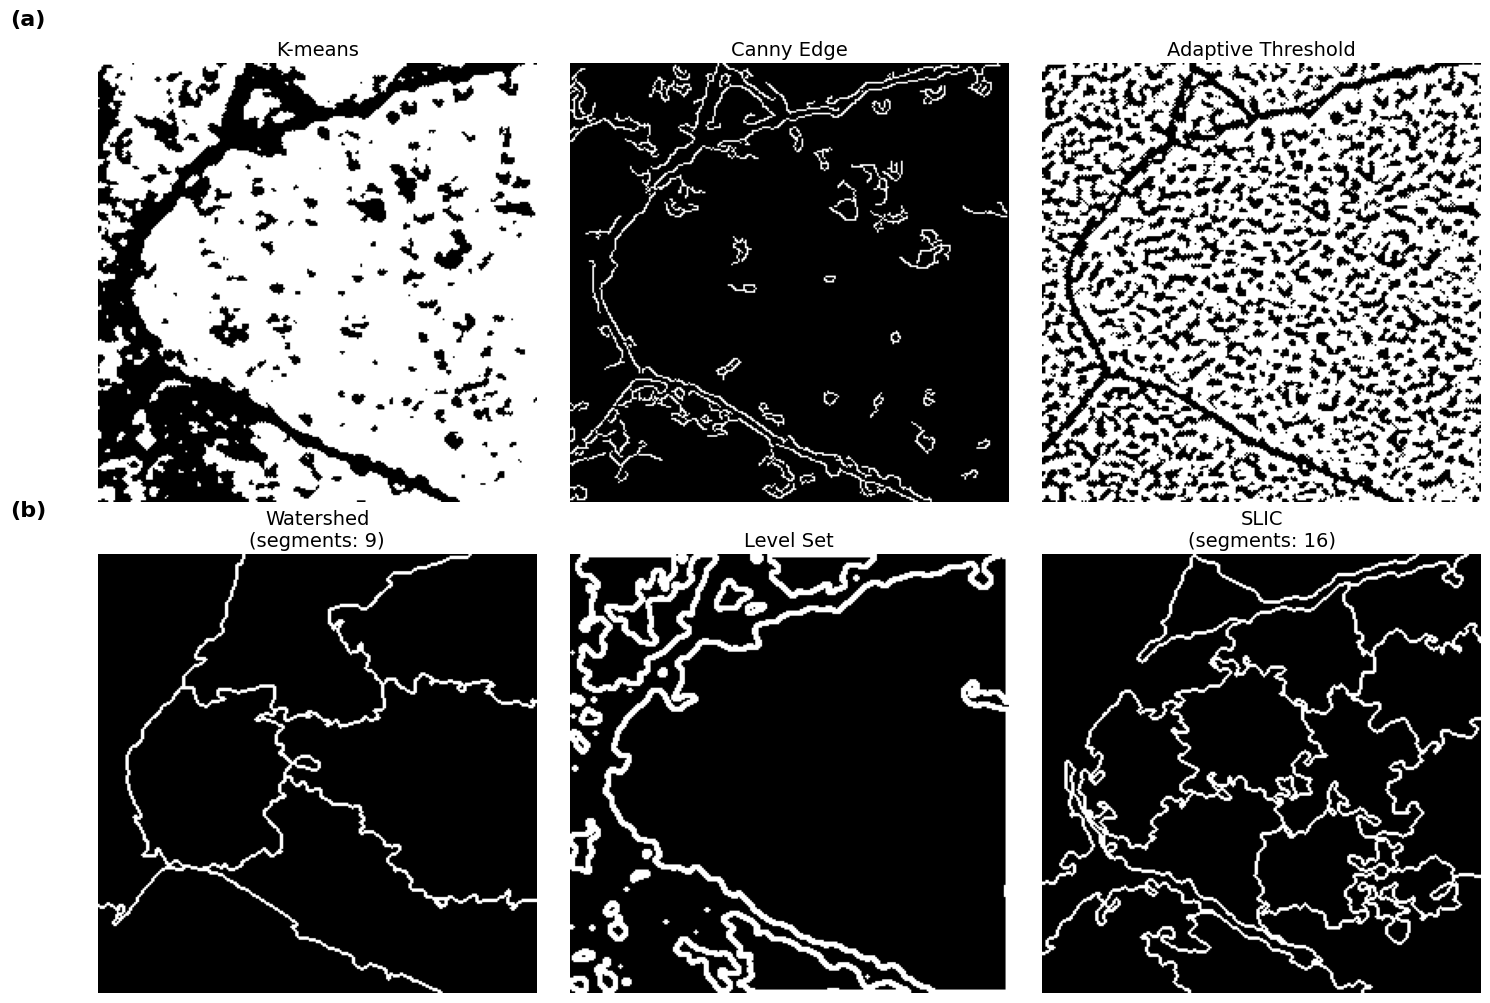

所有分割结果已保存到 segm_results 目录


In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic, mark_boundaries, watershed, morphological_chan_vese
from skimage.filters import sobel
from skimage.color import gray2rgb
from PIL import Image
import matplotlib.pyplot as plt
import os

def multiple_segmentation(image_path, save_dir='segm_results'):
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 读取图像
    img = np.array(Image.open(image_path).convert("L"))
    img_rgb = gray2rgb(img)  # 转换为RGB用于标记边界
    
    # 1. K-means分割
    pixel_values = img.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    kmeans_seg = labels.reshape(img.shape)
    if centers[0] > centers[1]:
        kmeans_seg = 1 - kmeans_seg
    
    # 2. Canny边缘检测
    canny_seg = cv2.Canny(img, 50, 150)
    
    # 3. 自适应阈值分割
    adaptive_thresh_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY, 11, 2)
    
    # 4. 分水岭分割
    gradient = sobel(img)
    segments_watershed = watershed(gradient, markers=10, compactness=0.0001)
    # 创建黑色背景
    watershed_boundaries = np.zeros_like(img_rgb)
    # 使用mark_boundaries但颜色改为白色
    watershed_boundaries = mark_boundaries(watershed_boundaries, segments_watershed, color=(1, 1, 1))
    
    # 5. Level Set分割
    level_set = morphological_chan_vese(img, num_iter=35, init_level_set='checkerboard')
    # 创建黑色背景
    level_set_display = np.zeros_like(img_rgb)
    contours = cv2.findContours((level_set * 255).astype(np.uint8), 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_SIMPLE)[0]
    # 绘制白色轮廓
    cv2.drawContours(level_set_display, contours, -1, (255, 255, 255), 2)
    level_set_display = level_set_display.astype(float) / 255.0
    
    # 6. SLIC超像素分割
    segments_slic = slic(img_rgb, n_segments=30, compactness=10, sigma=1)
    # 创建黑色背景
    slic_boundaries = np.zeros_like(img_rgb)
    # 使用mark_boundaries但颜色改为白色
    slic_boundaries = mark_boundaries(slic_boundaries, segments_slic, color=(1, 1, 1))
    
    # 保存各个结果
    # K-means
    plt.imsave(os.path.join(save_dir, '1_kmeans.png'), kmeans_seg, cmap='gray')
    
    # Canny
    plt.imsave(os.path.join(save_dir, '2_canny.png'), canny_seg, cmap='gray')
    
    # Adaptive Threshold
    plt.imsave(os.path.join(save_dir, '3_adaptive.png'), adaptive_thresh_img, cmap='gray')
    
    # Watershed
    plt.imsave(os.path.join(save_dir, '4_watershed.png'), watershed_boundaries)
    
    # Level Set
    plt.imsave(os.path.join(save_dir, '5_levelset.png'), level_set_display)
    
    # SLIC
    plt.imsave(os.path.join(save_dir, '6_slic.png'), slic_boundaries)
    
    # 显示结果
    fig = plt.figure(figsize=(15, 10))
    
    # 第一行 (a)
    # K-means结果
    ax1 = plt.subplot(231)
    plt.imshow(kmeans_seg, cmap='gray')
    plt.title('K-means', fontsize=14)
    ax1.text(-0.2, 1.1, '(a)', transform=ax1.transAxes, 
             verticalalignment='center', fontsize=16, fontweight='bold')
    plt.axis('off')
    
    # Canny结果
    ax2 = plt.subplot(232)
    plt.imshow(canny_seg, cmap='gray')
    plt.title('Canny Edge', fontsize=14)
    plt.axis('off')
    
    # 自适应阈值结果
    ax3 = plt.subplot(233)
    plt.imshow(adaptive_thresh_img, cmap='gray')
    plt.title('Adaptive Threshold', fontsize=14)
    plt.axis('off')
    
    # 第二行 (b)
    # 分水岭结果
    ax4 = plt.subplot(234)
    plt.imshow(watershed_boundaries)
    plt.title(f'Watershed\n(segments: {len(np.unique(segments_watershed))})', fontsize=14)
    ax4.text(-0.2, 1.1, '(b)', transform=ax4.transAxes, 
             verticalalignment='center', fontsize=16, fontweight='bold')
    plt.axis('off')
    
    # Level Set结果
    ax5 = plt.subplot(235)
    plt.imshow(level_set_display)
    plt.title('Level Set', fontsize=14)
    plt.axis('off')
    
    # SLIC结果
    ax6 = plt.subplot(236)
    plt.imshow(slic_boundaries)
    plt.title(f'SLIC\n(segments: {len(np.unique(segments_slic))})', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"所有分割结果已保存到 {save_dir} 目录")

# 使用示例
image_path = "new2/images/1_image_0.png"
multiple_segmentation(image_path)

In [1]:
from UNet import UNet
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import os
import numpy as np
from torchvision import transforms


def count_images_in_directory(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    files = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(valid_extensions)])
    return files

class Data_Loader(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = count_images_in_directory(self.image_dir)
        self.masks = count_images_in_directory(self.mask_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = Image.open(img_name).convert("L")
        image = transforms.ToTensor()(image)
        
        mask = Image.open(mask_name).convert('L')
        mask = transforms.ToTensor()(mask)
        
        return image, mask, img_name  # 返回图像路径用于保存结果

def segment_and_save(model, data_loader, save_dir="seg_pic"):
    model_path = "best_model.pth"
    net = UNet(in_channels=1, num_classes=1)
    net.load_state_dict(torch.load(model_path))

    net.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)  # 将模型移到GPU或CPU上

    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (image, mask, img_name) in enumerate(data_loader):
            image = image.to(device)  # 将输入数据移到GPU或CPU上

            # 模型预测
            output = net(image)
            preds = torch.sigmoid(output)
            preds = (preds > 0.1).float()  # 根据阈值进行二值化

            # 获取原始图像文件名（直接使用 DataLoader 返回的路径）
            image_name = os.path.splitext(os.path.basename(img_name[0]))[0]  # 去掉扩展名

            # 保存预测图像
            preds_image = preds.squeeze().cpu().numpy() * 255  # 转换为 0-255 的图像
            preds_image = Image.fromarray(preds_image.astype(np.uint8))  # 转换为 PIL 图像
            preds_image.save(os.path.join(save_dir, f"{image_name}.png"))  # 使用原始文件名保存


# 加载训练集和测试集
new_image_dir = os.path.join('new2', 'images')
new_mask_dir = os.path.join('new2', 'masks')
new_dataset = Data_Loader(new_image_dir, new_mask_dir)

# 拆分为训练集和验证集
train_size = int(0.8 * len(new_dataset))
test_size = len(new_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [train_size, test_size])

# 创建 DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
new_loader = DataLoader(dataset=new_dataset, batch_size=1, shuffle=False)

# 创建模型
net = UNet(in_channels=1, num_classes=1)

# 对数据集进行分割并保存分割结果
segment_and_save(net, new_loader, save_dir="base_pic")


/tmp/ipykernel_849/1222734759.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "in_conv.double_conv.5.weight", "in_conv.double_conv.5.bias", "in_conv.double_conv.5.running_mean", "in_conv.double_conv.5.running_var", "down1.downsampling.1.double_conv.5.weight", "down1.downsampling.1.double_conv.5.bias", "down1.downsampling.1.double_conv.5.running_mean", "down1.downsampling.1.double_conv.5.running_var", "down2.downsampling.1.double_conv.5.weight", "down2.downsampling.1.double_conv.5.bias", "down2.downsampling.1.double_conv.5.running_mean", "down2.downsampling.1.double_conv.5.running_var", "down3.downsampling.1.double_conv.5.weight", "down3.downsampling.1.double_conv.5.bias", "down3.downsampling.1.double_conv.5.running_mean", "down3.downsampling.1.double_conv.5.running_var", "down4.downsampling.1.double_conv.5.weight", "down4.downsampling.1.double_conv.5.bias", "down4.downsampling.1.double_conv.5.running_mean", "down4.downsampling.1.double_conv.5.running_var", "up1.conv.double_conv.5.weight", "up1.conv.double_conv.5.bias", "up1.conv.double_conv.5.running_mean", "up1.conv.double_conv.5.running_var", "up2.conv.double_conv.5.weight", "up2.conv.double_conv.5.bias", "up2.conv.double_conv.5.running_mean", "up2.conv.double_conv.5.running_var", "up3.conv.double_conv.5.weight", "up3.conv.double_conv.5.bias", "up3.conv.double_conv.5.running_mean", "up3.conv.double_conv.5.running_var", "up4.conv.double_conv.5.weight", "up4.conv.double_conv.5.bias", "up4.conv.double_conv.5.running_mean", "up4.conv.double_conv.5.running_var". 
	Unexpected key(s) in state_dict: "in_conv.double_conv.3.weight", "in_conv.double_conv.4.bias", "in_conv.double_conv.4.running_mean", "in_conv.double_conv.4.running_var", "in_conv.double_conv.4.num_batches_tracked", "down1.downsampling.1.double_conv.3.weight", "down1.downsampling.1.double_conv.4.bias", "down1.downsampling.1.double_conv.4.running_mean", "down1.downsampling.1.double_conv.4.running_var", "down1.downsampling.1.double_conv.4.num_batches_tracked", "down2.downsampling.1.double_conv.3.weight", "down2.downsampling.1.double_conv.4.bias", "down2.downsampling.1.double_conv.4.running_mean", "down2.downsampling.1.double_conv.4.running_var", "down2.downsampling.1.double_conv.4.num_batches_tracked", "down3.downsampling.1.double_conv.3.weight", "down3.downsampling.1.double_conv.4.bias", "down3.downsampling.1.double_conv.4.running_mean", "down3.downsampling.1.double_conv.4.running_var", "down3.downsampling.1.double_conv.4.num_batches_tracked", "down4.downsampling.1.double_conv.3.weight", "down4.downsampling.1.double_conv.4.bias", "down4.downsampling.1.double_conv.4.running_mean", "down4.downsampling.1.double_conv.4.running_var", "down4.downsampling.1.double_conv.4.num_batches_tracked", "up1.conv.double_conv.3.weight", "up1.conv.double_conv.4.bias", "up1.conv.double_conv.4.running_mean", "up1.conv.double_conv.4.running_var", "up1.conv.double_conv.4.num_batches_tracked", "up2.conv.double_conv.3.weight", "up2.conv.double_conv.4.bias", "up2.conv.double_conv.4.running_mean", "up2.conv.double_conv.4.running_var", "up2.conv.double_conv.4.num_batches_tracked", "up3.conv.double_conv.3.weight", "up3.conv.double_conv.4.bias", "up3.conv.double_conv.4.running_mean", "up3.conv.double_conv.4.running_var", "up3.conv.double_conv.4.num_batches_tracked", "up4.conv.double_conv.3.weight", "up4.conv.double_conv.4.bias", "up4.conv.double_conv.4.running_mean", "up4.conv.double_conv.4.running_var", "up4.conv.double_conv.4.num_batches_tracked". 
	size mismatch for in_conv.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for down1.downsampling.1.double_conv.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down2.downsampling.1.double_conv.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down3.downsampling.1.double_conv.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down4.downsampling.1.double_conv.4.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3, 3]).
	size mismatch for up1.conv.double_conv.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up2.conv.double_conv.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up3.conv.double_conv.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up4.conv.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).

IOU值最高的5张图片：
IOU系数: 0.6388
IOU系数: 0.6380
IOU系数: 0.6347
IOU系数: 0.6279
IOU系数: 0.6230


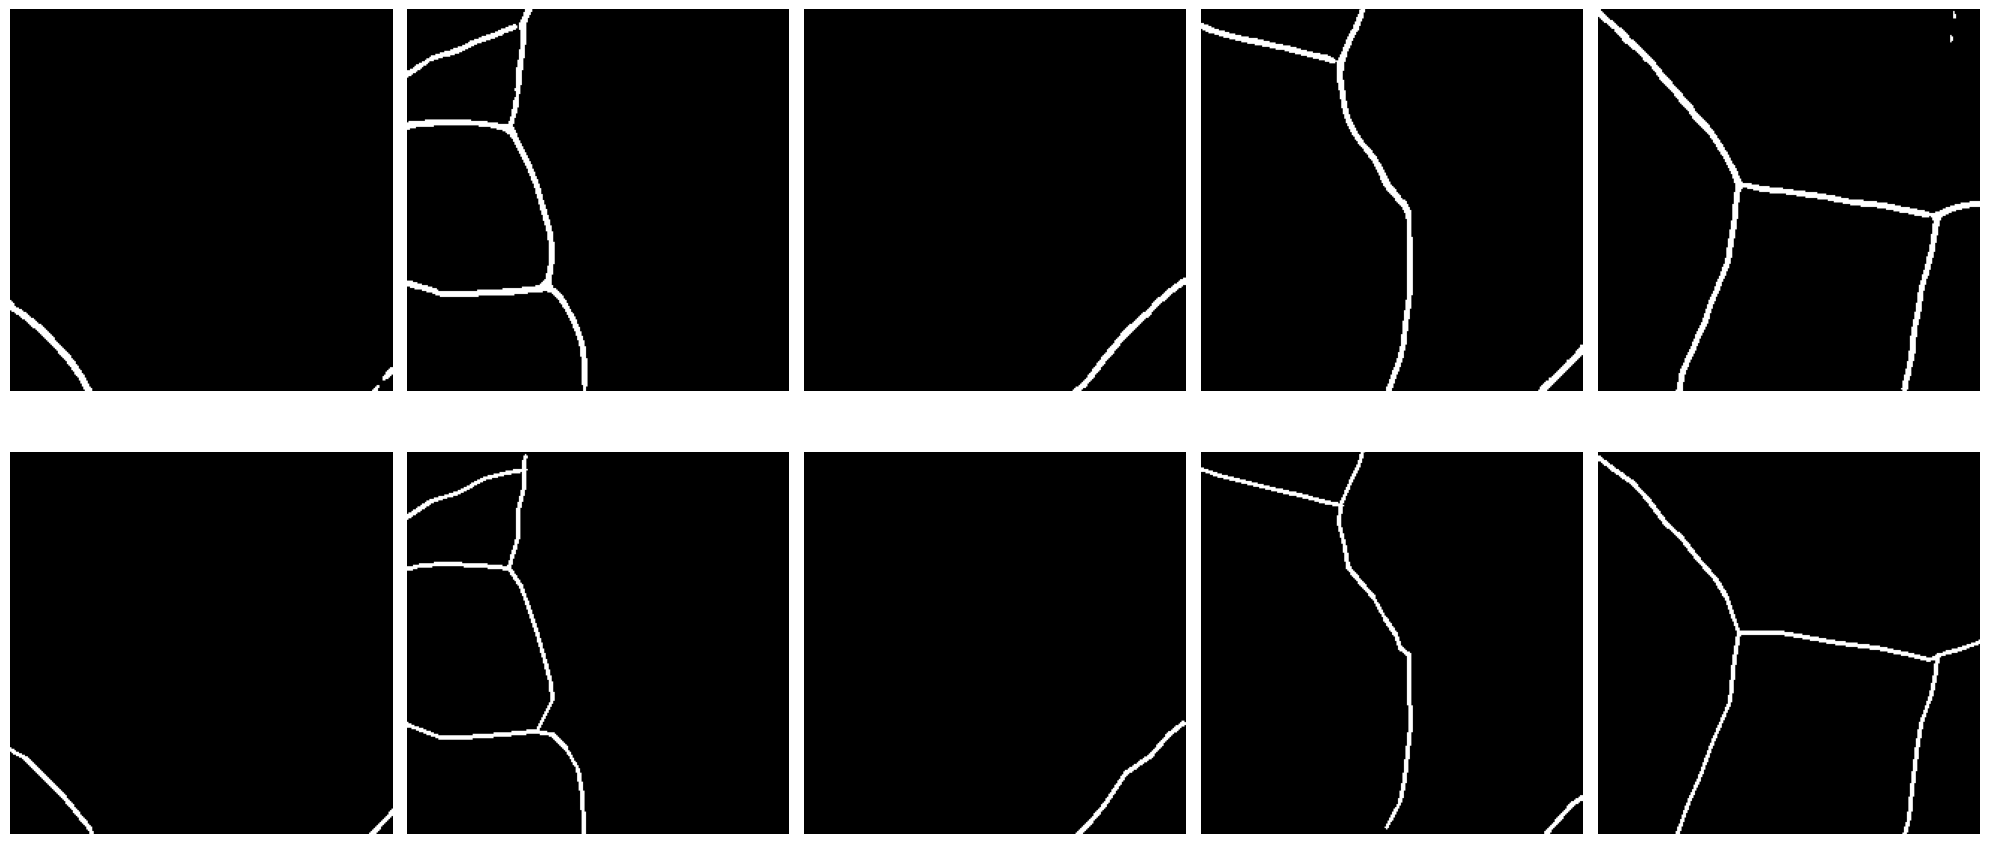

In [5]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    if union == 0:
        return 0
    return intersection / union

def visualize_best_cases():
    # 路径设置
    gt_folder = "new2/masks"
    pred_folder = "aug_all_pic"
    
    iou_scores = []
    
    # 遍历ground truth文件夹
    for filename in os.listdir(gt_folder):
        if filename.endswith('.png'):
            pred_filename = filename.replace('mask', 'image')
            
            gt_path = os.path.join(gt_folder, filename)
            pred_path = os.path.join(pred_folder, pred_filename)
            
            if os.path.exists(pred_path):
                gt = np.array(Image.open(gt_path)) / 255
                pred = np.array(Image.open(pred_path)) / 255
                
                gt = (gt > 0.5).astype(np.float32)
                pred = (pred > 0.5).astype(np.float32)
                
                iou = calculate_iou(gt, pred)
                if iou > 0:
                    iou_scores.append((iou, gt, pred))
    
    # 按iou值降序排序
    iou_scores.sort(key=lambda x: x[0], reverse=True)
    
    # 创建一个大图显示最好的5个结果
    plt.figure(figsize=(20, 10))  # 增加图片高度
    
    # 显示最高的5个
    print("IOU值最高的5张图片：")
    for idx, (iou, gt, pred) in enumerate(iou_scores[:5]):
        print(f"IOU系数: {iou:.4f}")
        
        # 创建子图，增加垂直间距
        plt.subplot(2, 5, idx+1)
        plt.subplots_adjust(hspace=0.1)  # 增加子图之间的垂直间距
        plt.imshow(pred, cmap='gray')
        #plt.title(f'Prediction\nIOU: {iou:.4f}')
        plt.axis('off')
        
        plt.subplot(2, 5, idx+6)
        plt.imshow(gt, cmap='gray')
        #plt.title('Ground Truth')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行函数
visualize_best_cases()